In [19]:
# AI model to classify space rocks
# how to install AI libraries from anaconda
# conda create -n myenv python=3.12 pandas jupyter seaborn scikit-learn keras pytorch pillow
# conda install pytorch torchvision

In [20]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

In [22]:
import torchvision
from torchvision import datasets, transforms, models

In [23]:
from PIL import Image

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
# Tell the machine what folder contains the image data
data_dir = './Data'

# Read the data, crop and resize the images, split data into two groups: test and train
def load_split_train_test(data_dir, valid_size = .2):

    # Transform the images to train the model
    train_transforms = transforms.Compose([
                                       transforms.RandomResizedCrop(224),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])

    # Transform the images to test the model
    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                          transforms.Resize(224),
                                          transforms.ToTensor(),
                                      ])

    # Create two variables for the folders with the training and testing images
    train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=test_transforms)

    # Get the number of images in the training folder
    num_train = len(train_data)

    # Create a list of numbers from 0 to the number of (training images - 1)
    # Example: For 10 images, the variable is the list [0,1,2,3,4,5,6,7,8,9]
    indices = list(range(num_train))

    # If valid_size is .2, find the index of the image that represents 20% of the data
    # If there are 10 images, a split would result in 2
    # split = int(np.floor(.2 * 10)) -> int(np.floor(2)) -> int(2) -> 2
    split = int(np.floor(valid_size * num_train))

    # Randomly shuffle the indices
    # For 10 images, an example would be that indices is now the list [2,5,4,6,7,1,3,0,9,8]
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    # With the indices randomly shuffled, 
    # grab the first 20% of the shuffled indices, and store them in the training index list
    # grab the remainder of the shuffled indices, and store them in the testing index list
    # Given our example so far, this would result is:
    # train_idx is the list [2,5] 
    # test_idx is the list [4,6,7,1,3,0,9,8]
    train_idx, test_idx = indices[split:], indices[:split]

    # Create samplers to randomly grab items from the training and testing indices lists
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create loaders to load 16 images from the train and test data folders
    # Images are chosen based on the shuffled index lists and by using the samplers
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    # Return the loaders so you can grab images randomly from the training and testing data folders
    return trainloader, testloader

# Using the function that shuffles images,
# create a trainloader to load 20% of the images
# create a testloader to load 80% of the images
trainloader, testloader = load_split_train_test(data_dir, .2)

# Print the type of rocks that are included in the trainloader
print(trainloader.dataset.classes)

['Basalt', 'Highland']


In [26]:
# Transform an image into pixels and resize it
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                   transforms.Resize(224),
                                   transforms.ToTensor(),
                                 ])

# Randomly select a set of images by using a similar approach as the load_split_train_test function
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    # Create an iterator to iterate over the shuffled images in the test image dataset
    dataiter = iter(loader)

    # Get and return the images and labels from the iterator
    images, labels = next(dataiter)
    return images, labels

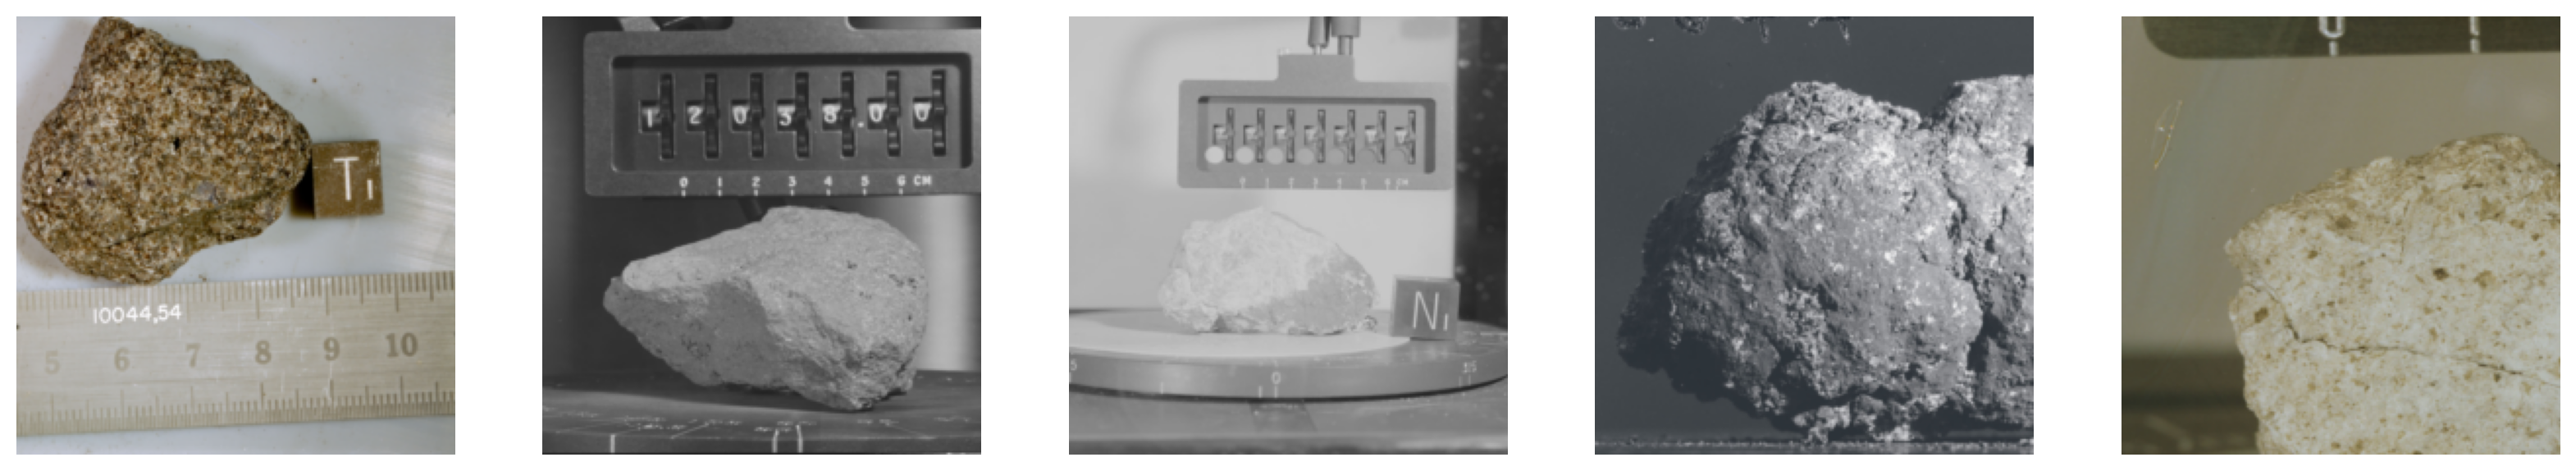

In [27]:
# Show five images - you can change this number
images, labels = get_random_images(5)

# Convert the array of pixels to an image
to_pil = transforms.ToPILImage()
fig=plt.figure(figsize=(20,20))

# Get a list of all classes in the training data
classes=trainloader.dataset.classes

# Draw the images in a plot to display in the notebook
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    plt.axis('off')
    plt.imshow(image)

# Display all of the images 
plt.show()

In [28]:
# Determine if you're using a CPU or a GPU device to build the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

c:\Users\parkj\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\parkj\anaconda3\envs\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\parkj/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [29]:
# Build all the neurons
for param in model.parameters():
     param.requires_grad = False

# Wire the neurons together to create the neural network
model.fc = nn.Sequential(nn.Linear(2048, 512),
                               nn.ReLU(),
                               nn.Dropout(0.2),
                               nn.Linear(512, 2),
                               nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# Add the neural network to the device
model.to(device)

print('done')

done
